# CL for Multiannotator Data Benchmarking [cifar10h]
This notebook uses the results from the ``model_train_pred.ipynb`` notebook to evaluate model performance.

Before running this notebook, make sure both cifar10 pngs and cifar10h datasets are downloaded locally:
1. ``pip install cifar2png`` #install png installer for cifar10 images
2. ``cifar2png cifar10 ./data/cifar10 --name-with-batch-index`` #download the cifar10 png images
3. ``cd data & git clone https://github.com/jcpeterson/cifar-10h.git`` #download cifar-10h dataset
5. Unizip ``cifar10h-raw`` and extract files out of ``cifar10-raw`` folder
4. Run ``create_labels_df.ipynb`` to update image paths

Notebook creates ``./data/model_data/cifar10_test_consensus_dataset.csv``

# 1. Data Loading/Pre Process -- only run once

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, \
                            roc_curve, accuracy_score, log_loss, precision_recall_fscore_support
from matplotlib import pyplot as plt
from IPython.display import Image, display
from scipy import stats

# cleanlab imports
import cleanlab
from cleanlab.multiannotator import get_label_quality_multiannotator, get_multiannotator_stats # only in hui wen directory
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
from cleanlab.filter import find_label_issues

# local imports
from utils.eval_metrics import lift_at_k
from utils.active_learning_scores import least_confidence
# experimental version of label quality ensemble scores with additional weighting schemes
from utils.label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

path = os.getcwd()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

fig_size_small = (5, 8)
fig_size_big = (15,10)

## Load Cifar10h Data

In [2]:
# If this line throws an error, make sure you correctly downloaded and unzipped cifar10h-raw data
pred_probs_multiannotator = np.load('./data/cifar10h/cifar10h-probs.npy')
c10h_df = pd.read_csv('./data/cifar10h/cifar10h-raw.csv')
c10h_df = c10h_df[c10h_df.cifar10_test_test_idx != -99999] # dropping all attention check trials

#### Restructure dataset into following arrays:
- ``c10h_num_datapoints: (N)``, ``c10h_num_annotators: (M)``
- ``c10h_labels: (N,M)``
- ``c10h_labels_error_mask: (N,M)`` where True is error
- ``c10h_annotator_mask: (N,M)`` where True is annotator x anotated that
- ``c10h_true_labels: (K=10,000,)``
- ``c10h_true_images: (K=10,000,)``

In [3]:
# initialize arrays
c10h_num_datapoints = c10h_df['cifar10_test_test_idx'].max() + 1
c10h_num_annotators = c10h_df['annotator_id'].max() + 1

c10h_labels = np.full((c10h_num_datapoints, c10h_num_annotators), np.nan) # all annotator labels np.full([height, width, 9], np.nan)
c10h_labels_error_mask = np.zeros((c10h_num_datapoints, c10h_num_annotators), dtype=bool) # mask of annotator errors
c10h_annotator_mask = np.zeros((c10h_num_datapoints, c10h_num_annotators), dtype=bool) # mask of what each person annotated

c10h_true_labels = np.zeros((c10h_num_datapoints, ))
c10h_true_images = np.empty((c10h_num_datapoints, ) ,dtype=object)

c10h_annotator_data = (c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images)

In [4]:
# get annotator labels as numpy array (N=labels, M=annotators)
for annotator_id in range(c10h_num_annotators):
    adf = c10h_df[c10h_df.annotator_id == annotator_id] # 200 annotations per annotator
    annotations_idx = adf['cifar10_test_test_idx'].values
    annotations = adf['chosen_label'].values
    errors = adf['correct_guess'].values
    
    c10h_labels[annotations_idx, annotator_id] = annotations
    c10h_labels_error_mask[annotations_idx, annotator_id] = errors
    c10h_annotator_mask[annotations_idx, annotator_id] = True

# get true labels as numpy array (N = true labels,)
idx_to_label = \
[(idx,label,image) for idx,label,image in zip(c10h_df['cifar10_test_test_idx'],c10h_df['true_label'],c10h_df['image_filename'])]
idx_to_label = list(set(idx_to_label))

idx = [idx_to_label[0] for idx_to_label in idx_to_label]
true_label = [idx_to_label[1] for idx_to_label in idx_to_label]
htrue_image = [idx_to_label[2] for idx_to_label in idx_to_label]

c10h_true_labels[idx] = true_label
c10h_true_images[idx] = htrue_image

#### Helper functions for cifar10h dataset sampling and analysis

In [5]:
# Get accuracy of individual annotators on the points they labeled
def plt_annotator_accuracy(labels_error_mask, annotator_mask):
    plt.rcParams["figure.figsize"] = fig_size_small
    
    annotator_accuracy = labels_error_mask.sum(axis=0) / annotator_mask.sum(axis=0)
    plt.boxplot(annotator_accuracy, )
    plt.show()

    df_describe = pd.DataFrame(annotator_accuracy, columns=['score'])
    return df_describe

# Returns sample labels/error_mask/annotator_mask where x_drop, y_drop are idxs that are dropped
def get_sample_labels(x_drop, y_drop, labels, labels_error_mask, annotator_mask):
    s_annotator_mask = annotator_mask.copy()
    s_annotator_mask[(x_drop,y_drop)] = 0
    s_labels_error_mask = s_annotator_mask & labels_error_mask
    s_labels = labels.copy()
    np.copyto(s_labels, np.nan, where=(s_annotator_mask==0)) 
    print('Total idxs dropped: ', annotator_mask.sum() - s_annotator_mask.sum())
    return s_labels, s_labels_error_mask, s_annotator_mask

# Returns a list of labeled indices to drop (random percent_dropped% of all labels)
def get_random_drop(c10h_annotator_mask, percent_dropped=0.4):
    x,y = np.where( c10h_annotator_mask == 1)
    drop_idx = np.random.choice(np.arange(len(x)), int(len(x)*percent_dropped), replace=False)
    x_drop = x[drop_idx]
    y_drop = y[drop_idx]
    return x_drop, y_drop

# Returns a list of labeled indices to drop (random length per row)
def get_random_drop_per_row(c10h_annotator_mask):
    x,y = np.where(c10h_annotator_mask == 1)
    idx_df = pd.DataFrame(zip(x,y),columns=['x','y'])
    for x_idx in range(idx_df['x'].max()+1):
        num_drop = np.random.randint(1, len(idx_df[idx_df['x'] == x_idx])+1)
        idx_df = idx_df.drop(idx_df[idx_df['x'] == x_idx].sample(num_drop).index)
    x_drop = idx_df['x'].values
    y_drop = idx_df['y'].values
    return x_drop, y_drop

# Returns a list of labeled indices to drop (random percent_dropped% of labels per annotator)
def get_random_drop_per_annotator(c10h_annotator_mask, percent_dropped=0.4):
    rows_dropped = int(200 * percent_dropped)
    print('Total rows dropped per annotator: ', rows_dropped)
    x,y = np.where( c10h_annotator_mask == 1)
    df_delete = pd.DataFrame(zip(x,y),columns=['x','y'])
    df_keep = df_delete.drop(df_delete.groupby('y').sample(n=200 - rows_dropped).index)
    x_drop,y_drop = df_keep['x'].values, df_keep['y'].values
    return x_drop, y_drop

# Returns a list of labeled indices to drop 
# (Randomly drop until <= max_annotations per example. Try to minimize number of distinct annotators)
def get_random_drop_per_row_min_annotators(c10h_annotator_mask, max_annotations = 5):
    x,y = np.where(c10h_annotator_mask == 1)
    xy = set([(x_idx,y_idx) for x_idx,y_idx in zip(x,y)])
    idx_df = pd.DataFrame(zip(x,y),columns=['x','y'])
    idx_keep = []
    selected_annotators = set()
    for x_idx in range(idx_df['x'].max()+1):
        Y = idx_df[idx_df['x'] == x_idx]['y']
        seen_annotators = set(Y).intersection(selected_annotators)
        if len(seen_annotators) < max_annotations: # We need to randomly select more annotators to greedy add
            num_to_find = max_annotations - len(seen_annotators)
            y_keep = set(np.random.choice(list(set(Y).difference(seen_annotators)), num_to_find, replace=False))
            selected_annotators = selected_annotators.union(y_keep)
            y_keep = seen_annotators.union(y_keep)
        else: # We have enough annotators and need to randomly select annotations out of the guys we have
            y_keep = np.random.choice(list(seen_annotators), max_annotations,replace=False)
        xy_keep = [(x_idx,y) for y in y_keep]
        idx_keep.extend(xy_keep)
    xy = xy.difference(set(idx_keep))
    x_drop = [xy_idx[0] for xy_idx in xy]
    y_drop = [xy_idx[1] for xy_idx in xy]
    return x_drop, y_drop

#### Helper functions for getting and analyzing consensus labels
- consensus_labels are determined based on the individual labels of all annotators

In [6]:
# Determines the consensus_labels
def get_consensus_labels(labels_multiannotator, pred_probs=None):
    
    labels = np.array(labels_multiannotator) # needs to be numpy
    if pred_probs is None:
        pred_counts = labels.sum(axis=1)
        pred_probs = labels / pred_counts[:,np.newaxis]
        
    mode_labels_multiannotator = labels_multiannotator.mode(axis=1)
    consensus_labels = []
    for i in range(len(mode_labels_multiannotator)):
        consensus_labels.append( int(mode_labels_multiannotator.iloc[i][pred_probs[i][mode_labels_multiannotator.iloc[i].dropna().astype(int).to_numpy()
                    ].argmax()
                ]
            )
        )
    return np.array(consensus_labels)

# Get consensus labels and calculate accuracy, precision, recall, f1
def get_consensus_label_accuracy(labels, pred_probs, true_labels):
    labels_df = pd.DataFrame(labels)
    consensus_labels = get_consensus_labels(labels_df, pred_probs)
    consensus_labels_accuracy = (true_labels == consensus_labels).sum() / 10000
    print('Consensus label accuracy: ', consensus_labels_accuracy)
    print('\nPer class scores:')
    p, r, f1, _ = precision_recall_fscore_support(true_labels, consensus_labels)
    results_df = pd.DataFrame(zip(p,r,f1), columns=['precision', 'recall', 'f1'])
    return results_df

# Plots the distribution of annotator agreement for correct/incorrect labels
def plot_labels_multiannotator(labels, true_labels, pred_probs_multiannotator=None):
    plt.rcParams["figure.figsize"] = fig_size_small
    
    labels_multiannotator = pd.DataFrame(labels)
    
    if pred_probs_multiannotator is None:
        pred_counts = labels.sum(axis=1)
        pred_probs_multiannotator = labels / pred_counts[:,np.newaxis]

    consensus_labels = get_consensus_labels(labels_multiannotator, pred_probs_multiannotator)
    consensus_labels_tile = np.repeat(consensus_labels[:,np.newaxis], labels_multiannotator.shape[1], axis=1)
    c10h_num_annotators_per_ex = np.count_nonzero(~np.isnan(labels), axis=1)
    annotator_agreement = (labels_multiannotator == consensus_labels_tile) # Number of annotators matches consensus
    annotator_agreement = annotator_agreement.sum(axis=1)
    bin_consensus = (true_labels == consensus_labels) + 0
    consensus_accuracy = pd.DataFrame(zip(annotator_agreement,bin_consensus), columns=['annotator_agreement','bin_consense'])
    _ = consensus_accuracy.boxplot(by=['bin_consense'], figsize=(7,7))
    consensus_accuracy = consensus_accuracy.groupby('bin_consense')[['annotator_agreement']].sum().reset_index()

    return consensus_accuracy

# Returns spearman correlation given two scores, checks for nans
def get_spearman_correlation(x, y):
    num_nans_x = np.sum(np.isnan(x))
    num_nans_y = np.sum(np.isnan(y))
    
    if num_nans_x > 0:
        x = np.nan_to_num(x)
        print('First param contains nans. Replacing', num_nans_x, 'nans with 0')
    if num_nans_y > 0:
        y = np.nan_to_num(y)
        print('First param contains nans. Replacing', num_nans_y, 'nans with 0')

    return stats.spearmanr(x, y)

## Load Cifar10 test and model output data
- model can be trained/predictions can be generated with the ``model_train_pred.ipynb`` file

In [7]:
# dictionaries to map to display name
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

model_display_name_dict = {"resnet18": "ResNet-18",}

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

# args to pass to get_label_quality_scores()
# TODO: add more consensus metrics
score_params_consensus = \
[
    ("majority", False),
#     ("dawid-skeen", False),
]

#### Helper functions to match label indices, calculate and plot model performance

In [8]:
# Matches indices of model trained data to cifar10h annotation dataset
def match_label_indices_old(numpy_out_folder, c10h_annotator_data, model):
    # read numpy files from model_train_pred
    pred_probs = np.load(numpy_out_folder + "test_pred_probs_" + model + ".npy")
    pred_labels = np.load(numpy_out_folder + "test_preds_" + model + ".npy")
    true_labels = np.load(numpy_out_folder + "test_labels_" + model + ".npy")
    images = np.load(numpy_out_folder + "test_images_" + model + ".npy", allow_pickle=True)
    idxs = [int(image.split('/')[-1][-8:-4]) for image in images]
    
    # set all cifar10h annotator data to the correct indexing
    c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images = c10h_annotator_data
    
    c10h_true_labels = c10h_true_labels[idxs]
    c10h_true_images = c10h_true_images[idxs]
    c10h_labels = c10h_labels[idxs]
    c10h_labels_error_mask = c10h_labels_error_mask[idxs]
    c10h_annotator_mask =  c10h_annotator_mask[idxs]
    
    # check cifar10h ordering matches what our model predicted on
    assert np.array_equal(c10h_true_labels, true_labels)
 
    c10h_annotator_data = (c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images)
    c10_model_data = (pred_probs, pred_labels, true_labels, images)
    
    return c10_model_data, c10h_annotator_data

# Matches indices of model trained data to cifar10h annotation dataset
def match_label_indices(numpy_out_folder, c10h_annotator_data):
    # read numpy files from model_train_pred
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    pred_labels = np.load(numpy_out_folder + "true_labels.npy")
    true_labels = np.load(numpy_out_folder + "labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    idxs = [int(image.split('/')[-1][-8:-4]) for image in images]
    
    print(idxs[:10])
    print(images[:10])
    # set all cifar10h annotator data to the correct indexing
    c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images = c10h_annotator_data
    
    print(c10h_true_images[:10])
    c10h_true_labels = c10h_true_labels[idxs]
    c10h_true_images = c10h_true_images[idxs]
    c10h_labels = c10h_labels[idxs]
    c10h_labels_error_mask = c10h_labels_error_mask[idxs]
    c10h_annotator_mask =  c10h_annotator_mask[idxs]
    
    # check cifar10h ordering matches what our model predicted on
    assert np.array_equal(c10h_true_labels, true_labels)
 
    c10h_annotator_data = (c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images)
    c10_model_data = (pred_probs, pred_labels, true_labels, images)
    
    return c10_model_data, c10h_annotator_data


#c10h true labels passed for assertion (checks idx just in case)
def benchmark_results_base(labels, true_labels, score_params, model):
    plt.rcParams["figure.figsize"] = fig_size_big
        
    # create boolean mask of label errors
    label_errors_target = labels != true_labels
    
    results = []
    results_list = []

    for score_param in score_params:
        method, adjust_pred_probs = score_param
        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 11000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
        # save results
        results = {
            "dataset": "cifar10",
            "model": model,
            "noise_config": "nan",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }
        # add the lift at k metrics
        results.update(lift_at_k_dict)
        # save results
        results_list.append(results)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute au-roc curve using label quality scores
        fpr, tpr, thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)

        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": "cifar10",
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
        
        # plot prc
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10 \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f"{method}-{str(adjust_pred_probs)}")
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("AU ROC Curve: Label Error Detection on CIFAR-10 \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()
        
    return results_list, precision_recall_curve_results

# TODO: add back in adjusted_pred_probs once multiannotator has that param
def benchmark_results_annotators(c10h_labels, c10h_true_labels, score_params, model):
    plt.rcParams["figure.figsize"] = fig_size_big    
    results = []
    results_list = []
    
    c10h_labels = pd.DataFrame(c10h_labels)

    for score_param in score_params:
        method, adjust_pred_probs = score_param

        label_quality_multiannotator, _ = get_label_quality_multiannotator(c10h_labels, pred_probs, consensus_method=method, return_annotator_stats = True, verbose=False)
        # create boolean mask of label errors
        labels = label_quality_multiannotator['consensus_label'] 
        label_errors_target = labels != c10h_true_labels # labels can change to annotator labels!!
        # compute scores
        label_quality_scores = label_quality_multiannotator['quality_of_consensus']
        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 11000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
        # save results
        results = {
            "dataset": "cifar10",
            "model": model,
            "noise_config": "nan",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }
        # add the lift at k metrics
        results.update(lift_at_k_dict)
        # save results
        results_list.append(results)

        # compute precision-recall curve using label quality scores
        precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

        # compute au-roc curve using label quality scores
        fpr, tpr, thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)

        precision_recall_curve_results = {
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": "cifar10",
            "model": model,
            "label_quality_scores": label_quality_scores,
            "precision": precision,
            "recall": recall,
            "thresholds": thresholds
        }
        
        # plot prc
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f"{method}-{str(adjust_pred_probs)}")
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("AU ROC Curve \n Model: resnet-18", fontsize=14, fontweight="bold")
        plt.legend()
        
    return results_list, precision_recall_curve_results

### Load cifar10test and model output data [this does indexing]

In [9]:
# # get data
# model_folder = 'model_data_070622'
# numpy_out_folder = './data/' + model_folder + '/' # folder containing model train data
# model = "resnet18" # can also be: "swin_base_patch4_window7_224"
# c10_model_data, c10h_annotator_data = match_label_indices_old(numpy_out_folder, c10h_annotator_data, model)

# # unpack fixed indices
# c10h_labels, c10h_labels_error_mask, c10h_annotator_mask, c10h_true_labels, c10h_true_images = c10h_annotator_data
# pred_probs, pred_labels, true_labels, images = c10_model_data

### Optional: Drop out annotators from data
- Use either ``get_random_drop_per_annotator()``, ``get_random_drop_per_row_min_annotators()``, ``get_random_drop_per_row()``, ``get_random_drop()``
- TODO: ``get_random_drop_per_row()`` very slow, needs to be optimized with lambda
- TODO: Fix loopy logic in ``get_random_drop_per_row_min_annotators()``

In [10]:
x_drop, y_drop = get_random_drop_per_row_min_annotators(c10h_annotator_mask, 5)
c10h_labels, c10h_labels_error_mask, c10h_annotator_mask = \
                    get_sample_labels(x_drop, y_drop, c10h_labels, c10h_labels_error_mask, c10h_annotator_mask)

print(f'Make sure {c10h_annotator_mask.sum(axis=1).max()} <= max_annotations and { c10h_annotator_mask.sum(axis=1).min()} > 0: ')

x_drop, y_drop = get_random_drop_per_row(c10h_annotator_mask)
c10h_labels, c10h_labels_error_mask, c10h_annotator_mask = \
                    get_sample_labels(x_drop, y_drop, c10h_labels, c10h_labels_error_mask, c10h_annotator_mask)
print(f'Make sure {c10h_annotator_mask.sum(axis=1).max()} <= max_annotators and { c10h_annotator_mask.sum(axis=1).min()} > 0: ')

# drop all empty annotators
drop_axis = c10h_labels.copy()
c10h_labels = c10h_labels[:, ~np.isnan(drop_axis).all(axis=0)]
c10h_labels_error_mask = c10h_labels_error_mask[:, ~np.isnan(drop_axis).all(axis=0)]
c10h_annotator_mask = c10h_annotator_mask[:, ~np.isnan(drop_axis).all(axis=0)]

print(c10h_labels.shape, c10h_annotator_mask.shape)

Total idxs dropped:  464200
Make sure 5 <= max_annotations and 5 > 0: 
Total idxs dropped:  20071
Make sure 5 <= max_annotators and 1 > 0: 
(10000, 421) (10000, 421)


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

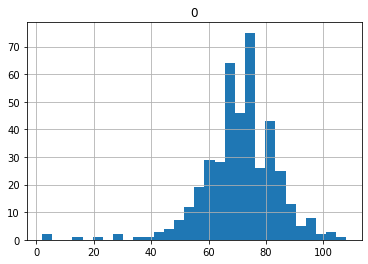

In [11]:
pd.DataFrame(c10h_annotator_mask.sum(axis=0)).hist(bins=30)

In [12]:
np.sum(c10h_annotator_mask.sum(axis=0) > 0)

421

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

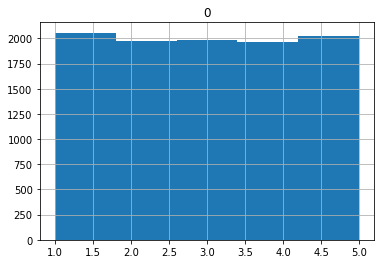

In [13]:
pd.DataFrame(c10h_annotator_mask.sum(axis=1)).hist(bins=5)

In [14]:
np.save('./benchmark_data/c10h_labels_range_1_5', c10h_labels)

### Get consensus labels & save them

In [16]:
from cleanlab.multiannotator import _get_consensus_label
consensus_labels = _get_consensus_label(pd.DataFrame(c10h_labels))

In [17]:
# TODO: lambda create new column
mini_df = c10h_df[['image_filename','true_category','cifar10_test_test_idx']].drop_duplicates()
image_locs = [path + 
              '/data/cifar10/test/' +
              mini_df[mini_df['image_filename'] == c10h_true_images[i]]['true_category'].item() +
              '/test_batch_index_' +
              str(mini_df[mini_df['image_filename'] == c10h_true_images[i]]['cifar10_test_test_idx'].item()).zfill(4) +
              '.png'
              for i in range(len(c10h_true_images))]
consensus_df = pd.DataFrame(zip(image_locs, consensus_labels), columns=['image', 'label'])
consensus_df.to_csv('./benchmark_data/cifar10_test_consensus_dataset_range_1_5.csv', index=False)

# 2. Benchmark Evaluation -- experiment as needed

**Major Benchmarks**
- How good is consensus quality-score for any given consensus
    - Plots: auroc, auprc
    - Scores: auroc
- How accurate are consensus labels: accuracy
    - Overall: accuracy
    - Per-class: precision,recall,f1 scores
- How good are annotator-quality scores
    - Distribution of individual annotator accuracy vs ground truth
    - Spearman correlation between annotator scores vs annotator accuracy

**Side Benchmarks**
- Annotator Agreement Consensus vs. Label Accuracy
- Annotator vs Model Accuracy
- Label quality scores distribution
- Worst Class per Annotator distribution

## How good is consensus quality-score for any given consensus 
## [model baseline]
#### AUROC vs AUPRC curves
- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability threshold
- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
- Precision-Recall curves: imbalanced datasets (more sensitive to positive class), ROC curves: balanced datasets
- Data behavior in curves is relatively similar (i.e. well performing label will perform well in both curves)

In [ ]:
results_list_base, precision_recall_curve_results_base = benchmark_results_base(pred_labels, true_labels, score_params, model)

In [ ]:
pd.DataFrame(results_list_base)

## [consensus labels, same metrics as base]

In [ ]:
results_list_base_con, precision_recall_curve_results_base_con = benchmark_results_base(consensus_labels, c10h_true_labels, score_params, model)

In [ ]:
pd.DataFrame(results_list_base_con)

## [consensus labels, new label_quality scores]

In [ ]:
# slow because calculates label_quality_multiannotator for each annotator ~ 1 min each
results_list_consensus, precision_recall_curve_results_consensus = benchmark_results_annotators(c10h_labels, c10h_true_labels, score_params_consensus, model)

### AUROC score per method
**Base model with labels = model predictions**

In [ ]:
pd.DataFrame(results_list_base)

**Base score calculations with labels = consensus labels**

In [ ]:
pd.DataFrame(results_list_base_con)

**Different Multiannotator label quality scoring methods**

In [ ]:
pd.DataFrame(results_list_consensus)

## How accurate are consensus labels
#### Overall accuracy and per-class precision, recall, f1 scores

In [ ]:
get_consensus_label_accuracy(c10h_labels, pred_probs, true_labels)

## How good are annotator-quality scores 
#### Distribution of individual annotator accuracy vs ground truth

In [ ]:
annotator_accuracy_df = plt_annotator_accuracy(c10h_labels_error_mask,  c10h_annotator_mask)
annotator_accuracy_df.describe()

#### Spearman Correlation
- Nonparametric measure of the monotonicity of the relationship between two datasets
- Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
- The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable
- TODO: figure out why spearman correlation is 0 when we randomly remove random number of datapoints per row

In [ ]:
label_quality_multiannotator, multiannotator_stats = get_label_quality_multiannotator(pd.DataFrame(c10h_labels), pred_probs, return_annotator_stats = True, verbose=False)

In [ ]:
quality_score = multiannotator_stats['overall_quality'].values
accuracy = annotator_accuracy_df['score'].values
get_spearman_correlation(quality_score, accuracy)

## Side Benchmarks
#### Annotator Agreement Consensus vs. Label Accuracy

In [ ]:
plot_labels_multiannotator(c10h_labels, c10h_true_labels)

#### Annotator vs Model accuracy

In [ ]:
# check how much the consensus labels differ from
c10h_labels_df = pd.DataFrame(c10h_labels)
consensus_labels = get_consensus_labels(c10h_labels_df, pred_probs)

print('Probability annotators alone correctly predict labels: ', (true_labels == consensus_labels).sum() / 10000)
model_pred_labels = np.argmax(pred_probs, axis=1) # true labels == to what the model is likeley to predict
print('Probability model alone correctly predicts labels: ', (model_pred_labels == true_labels).sum() / 10000) # suggests model is x% likeley to predict with the consensus
print('Similar prediction between model preds and consensus_labels: ', (model_pred_labels == consensus_labels).sum())

#### Label quality scores distribution

In [ ]:
label_quality_scores = get_label_quality_scores(consensus_labels, pred_probs)
pd.DataFrame(label_quality_scores, columns=['']).plot.hist(bins=30,)

#### Worst Class Per Annotator Distribution

In [ ]:
multiannotator_stats = get_multiannotator_stats(c10h_labels_df, pred_probs, consensus_labels, 'agreement')
multiannotator_stats['worst_class'].plot.hist(bins=10,)

# 3. Label Issue Visualization

In [ ]:
classes = {0:"airplane", 
           1:"automobile", 
           2:"bird", 
           3:"cat", 
           4:"deer",
           5:"dog", 
           6:"frog", 
           7:"horse", 
           8:"ship", 
           9:"truck"}

def get_label_issues(labels, pred_probs, true_labels, images):
    label_issues = find_label_issues(labels=labels,
                        pred_probs=pred_probs,
                        return_indices_ranked_by='self_confidence',
                        )
    issue_consensus_labels = labels[label_issues]
    issue_images = images[label_issues]
    issue_true_labels = true_labels[label_issues]
    issue_is_issue = (issue_consensus_labels != issue_true_labels) + 0
    issue_real_image_paths = [path + '/' + '/'.join(image.split('/')[-5:]) for image in issue_images]

    print('Number of label issues detected: ', len(label_issues))
    print('Number of true label issues: ', true_labels.shape[0] - np.sum(labels == true_labels))
    print('Number of true label issues detected: ', np.sum(issue_is_issue))
    
    issues_df = pd.DataFrame(zip(issue_consensus_labels, issue_true_labels, issue_is_issue, issue_real_image_paths),
            columns = ['label','true_label','is_issue','image_png'])
    return issues_df

def visualize_label_issues(issues_df, classes, scale=100):
    print('Visualizing', len(issues_df), 'issues\n')
    
    listOfImageNames = issues_df['image_png'].values

    for index, row in issues_df.iterrows():
        print('Correctly identified: ', bool(row['is_issue']), '\nGiven label: ', classes[row['label']], '\nTrue label: ', classes[row['true_label']],)
        image = Image(filename=row['image_png'])
        display(Image(filename=row['image_png'], width=scale))

#### Run find_label_issues on the consensus labels and visualize label issues.

In [ ]:
# check how much the consensus label issues differ from true labels
c10h_labels_df = pd.DataFrame(c10h_labels)
consensus_labels = get_consensus_labels(c10h_labels_df, pred_probs)
issues_df = get_label_issues(consensus_labels, pred_probs, true_labels, images)

In [ ]:
true_issues_df = issues_df[issues_df['is_issue'] == 1] # get a df of correctly identified true issues
# visualize_label_issues(issues_df, classes)
visualize_label_issues(true_issues_df, classes)

#### Run find_label_issues on an individual annotator's labels and visualize label issues.

In [ ]:
annotator_accuracy = c10h_labels_error_mask.sum(axis=0) /  c10h_annotator_mask.sum(axis=0)
worst_annotator = np.argmin(annotator_accuracy)
best_annotator = np.argmax(annotator_accuracy)
print('worst annotator: ', worst_annotator, 'accuracy: ', annotator_accuracy[worst_annotator])
print('best annotator: ', best_annotator, 'accuracy: ', annotator_accuracy[best_annotator])

In [ ]:
annotator_id = 1 # worst = 2561, best = 1957

a_c10h_labels = c10h_labels[:,annotator_id]
a_c10h_annotator_mask =  c10h_annotator_mask[:,annotator_id]
a_c10h_labels_error_mask = c10h_labels_error_mask[:,annotator_id]

a_labels = true_labels.copy()
a_labels[a_c10h_annotator_mask] = a_c10h_labels[a_c10h_annotator_mask]

print('Annotator accuracy: ', np.sum(a_labels[a_c10h_annotator_mask] == true_labels[a_c10h_annotator_mask]) / a_c10h_annotator_mask.sum())
print('Annotator accuracy: ', annotator_accuracy[annotator_id])
print('Num correctly labeled points for annotator ', annotator_id, ': ', np.sum(a_labels == true_labels))
print('Annotator + True label accuracy: ', np.sum(a_labels == true_labels) / len(a_labels))

issues_df = get_label_issues(a_labels, pred_probs, true_labels, images)